In [5]:
import keras
import numpy as np
%matplotlib inline
from keras import Model 
from keras.layers import *
import matplotlib.pyplot as plt
from keras.optimizers import SGD
from keras.models import Sequential
from keras.constraints import maxnorm
from DatasetHandler.BiwiBrowser import *
from keras.applications.vgg16 import VGG16
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import Convolution2D
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

/home/mcicek/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
def scale(arr):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(arr)
    # normalize the dataset and printscaler, 
    normalized = scaler.transform(arr)
    return normalized 

In [7]:
def reshaper(m, l, timesteps = 1):
    wasted = (m.shape[0] % timesteps)
    m, l = m[wasted:], l[wasted:]
    l = scale(l)
    m = m.reshape((int(m.shape[0]/timesteps), timesteps, m.shape[1], m.shape[2], m.shape[3]))
    l = l.reshape((int(l.shape[0]/timesteps), timesteps, l.shape[1]))
    l = l[:, -1, :]
    return m, l

In [22]:
num_datasets = 8

In [9]:
num_outputs = 1

In [10]:
timesteps = 1

In [27]:
keras.backend.clear_session()
def getFinalModel(num_outputs = num_outputs):
    dense_layer_1 = 1#int((patch_size[0] * patch_size[1]) / 1)0010#00000
    dense_layer_2 = 8
    inp = BIWI_Frame_Shape
    vgg_model = VGG16(weights='imagenet', include_top=False, input_shape = BIWI_Frame_Shape)
    rnn = Sequential()
    rnn.add(TimeDistributed(vgg_model, batch_size = timesteps, input_shape=(timesteps, inp[0], inp[1], inp[2])))#
    
    rnn.add(TimeDistributed(Flatten()))
    rnn.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, stateful=True)) # , activation='relu'
#    rnn.add(TimeDistributed(Dropout(0.2)))
    rnn.add(Dense(num_outputs))

    for layer in rnn.layers[:15]:
        layer.trainable = False
    rnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return rnn

In [28]:
full_model = getFinalModel(num_outputs = num_outputs)

In [29]:
biwi = readBIWIDataset(subjectList = [s for s in range(1, num_datasets+1)])#

Frames from /home/mcicek/Datasets/HeadPoses/biwi/hpdb/ have been started to read by 2018-12-23 03:01:39.020264
Subject 01's frames have been started to read 2018-12-23 03:01:39.025455
Subject 01's all frames have been read by 2018-12-23 03:01:39.025590
Subject 02's frames have been started to read 2018-12-23 03:01:39.030198
Subject 02's all frames have been read by 2018-12-23 03:01:39.030328
Subject 03's frames have been started to read 2018-12-23 03:01:39.036968
Subject 03's all frames have been read by 2018-12-23 03:01:39.037098
Subject 04's frames have been started to read 2018-12-23 03:01:39.043944
Subject 04's all frames have been read by 2018-12-23 03:01:39.044088
Subject 05's frames have been started to read 2018-12-23 03:01:39.051712
Subject 05's all frames have been read by 2018-12-23 03:01:39.051830
Subject 06's frames have been started to read 2018-12-23 03:01:39.055760
Subject 06's all frames have been read by 2018-12-23 03:01:39.055826
Subject 07's frames have been started

In [30]:
c = 0
frames, labelsList = [], []
for inputMatrix, labels in biwi:
    inputMatrix, labels = reshaper(inputMatrix, labels, timesteps = timesteps)
    if c < num_datasets-1:
        full_model.fit(inputMatrix, labels[:, :num_outputs], batch_size = timesteps, epochs=1, verbose=2, shuffle=False) #
        full_model.reset_states()
        frames.append(inputMatrix)
        labelsList.append(scale(labels))
    else:
        frames.append(inputMatrix)
        labelsList.append(scale(labels))
    c += 1
    print('Batch %d done!' % c)

Epoch 1/1
 - 17s - loss: 1.0141 - mean_absolute_error: 0.8008
Batch 1 done!
Epoch 1/1
 - 18s - loss: 1.0620 - mean_absolute_error: 0.8506
Batch 2 done!
Epoch 1/1
 - 26s - loss: 2.3540 - mean_absolute_error: 1.3915
Batch 3 done!
Epoch 1/1
 - 27s - loss: 2.1471 - mean_absolute_error: 1.2676
Batch 4 done!
Epoch 1/1
 - 34s - loss: 0.5649 - mean_absolute_error: 0.6061
Batch 5 done!
Epoch 1/1
 - 19s - loss: 0.8017 - mean_absolute_error: 0.7555
Batch 6 done!
Epoch 1/1
 - 26s - loss: 1.0310 - mean_absolute_error: 0.8267
Batch 7 done!
Batch 8 done!


In [31]:
test_inputMatrix, test_labels = frames[0], labelsList[0]

In [32]:
predictions = full_model.predict(test_inputMatrix, batch_size = timesteps)

In [33]:
output1 = numpy.concatenate((test_labels[:, :1], predictions[:, :1]), axis=1)

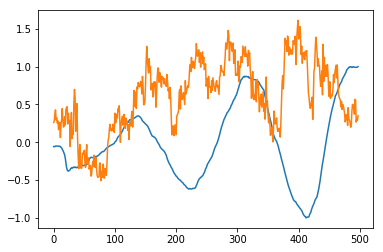

In [34]:
plt.plot(output1)

In [ ]:
output1 = numpy.concatenate((test_labels[:, :1], predictions[:, :1]), axis=1)
output2 = numpy.concatenate((test_labels[:, 1:2], predictions[:, 1:2]), axis=1)
output3 = numpy.concatenate((test_labels[:, 2:3], predictions[:, 2:3]), axis=1)

In [ ]:
# Three subplots sharing both x/y axes
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
ax1.plot(output1)
ax1.set_title('Sharing both axes')
ax2.plot(output2)
ax3.plot(output3)
# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)